In [46]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from statsmodels.stats.power import NormalIndPower
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns' , 50)
pd.set_option('display.width' , 120)

In [3]:
data_path = r"C:\Users\pc1\ab-project-sta\ab_test_data.csv"

df = pd.read_csv(data_path , parse_dates = ['date'] , low_memory = False)
df.head()

,TvC,date,traffic_source,device_type,browser_language,login_y_n,region,return_y_n,conversion
0,C,2021-02-14,Referrals,Mweb,Chinese,n,Southwest,y,1
1,C,2021-02-14,Direct,Iphone,English,y,West,y,0
2,C,2021-02-11,Email Marketing,Mweb,English,y,Northeast,y,0
3,C,2021-02-11,Referrals,Iphone,English,y,Southwest,n,0
4,C,2021-02-01,Referrals,Desktop,English,y,Northeast,n,0


In [4]:
print(df.shape) #show number row and columns
display(df.dtypes) #show type any data
display(df.isna().sum()) #show NAN on columns

display(df.sample(5, random_state=42))

(2000000, 9)


TvC                         object
date                datetime64[ns]
traffic_source              object
device_type                 object
browser_language            object
login_y_n                   object
region                      object
return_y_n                  object
conversion                   int64
dtype: object

TvC                 0
date                0
traffic_source      0
device_type         0
browser_language    0
login_y_n           0
region              0
return_y_n          0
conversion          0
dtype: int64

,TvC,date,traffic_source,device_type,browser_language,login_y_n,region,return_y_n,conversion
1828401,V1,2021-02-06,Organic,Desktop,Spanish,n,West,y,0
1200071,V1,2021-02-04,Organic,Mweb,English,n,Northeast,y,0
194849,C,2021-02-12,Organic,Iphone,English,y,Northeast,y,0
1629054,V1,2021-02-10,Organic,Mweb,English,n,West,y,0
191144,C,2021-02-02,Organic,Mweb,English,n,Midwest,y,0


In [15]:
df['TvC'].unique()

array(['C', 'V1'], dtype=object)

In [12]:
df = df.copy()

df['conversion'] = df['conversion'].astype(int)
df['date'] = pd.to_datetime(df['date'] , errors = 'coerce')
df['return_y_n'] = df['return_y_n'].map({'y':1, 'n':0})
df['login_y_n'] = df['login_y_n'].map({'y':1, 'n':0})


In [14]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 9 columns):
 #   Column            Dtype         
---  ------            -----         
 0   TvC               object        
 1   date              datetime64[ns]
 2   traffic_source    object        
 3   device_type       object        
 4   browser_language  object        
 5   login_y_n         float64       
 6   region            object        
 7   return_y_n        float64       
 8   conversion        int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 137.3+ MB


,TvC,date,traffic_source,device_type,browser_language,login_y_n,region,return_y_n,conversion
0,C,2021-02-14,Referrals,Mweb,Chinese,NaN,Southwest,NaN,1
1,C,2021-02-14,Direct,Iphone,English,NaN,West,NaN,0
2,C,2021-02-11,Email Marketing,Mweb,English,NaN,Northeast,NaN,0
3,C,2021-02-11,Referrals,Iphone,English,NaN,Southwest,NaN,0
4,C,2021-02-01,Referrals,Desktop,English,NaN,Northeast,NaN,0


In [26]:
df['group'] = df['TvC'].map({'C':'A' , 'V1':'B'})

summary = df.groupby('group').agg( users = ('conversion','count'),     
    conversions = ('conversion','sum')
).reset_index()

summary['conversation_rate'] = summary['conversions'] / summary['users']

display(summary)

,group,users,conversions,conversation_rate
0,A,1000000,100092,0.100092
1,B,1000000,109884,0.109884


In [31]:
cis = []

for _, row in summary.iterrows():
    count = int(row['conversions'])
    nobs = int(row['users'])
    ci_low, ci_upp = proportion_confint(count, nobs, alpha=0.05, method='normal')
    cis.append((ci_low, ci_upp))

summary['ci_low'] = [c[0] for c in cis]
summary['ci_upp'] = [c[1] for c in cis]
display(summary)

,group,users,conversions,conversation_rate,ci_low,ci_upp
0,A,1000000,100092,0.100092,0.099504,0.100680
1,B,1000000,109884,0.109884,0.109271,0.110497


In [34]:
count = summary['conversions'].astype(int).values
nobs = summary['users'].astype(int).values

z_stat , p_val = proportions_ztest(count , nobs , alternative = 'two-sided')
print(f"z-statistic = {z_stat: .4f}    ,   p-value = {p_val: .4f}")

z-statistic = -22.5877    ,   p-value =  0.0000


In [42]:
df.info()
df.head()
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 10 columns):
 #   Column            Dtype         
---  ------            -----         
 0   TvC               object        
 1   date              datetime64[ns]
 2   traffic_source    object        
 3   device_type       object        
 4   browser_language  object        
 5   login_y_n         float64       
 6   region            object        
 7   return_y_n        float64       
 8   conversion        int64         
 9   group             object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 152.6+ MB
(2000000, 10)


In [57]:
def cohens_h(p1 , p2):
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

pA = summary.loc[summary['group'] == 'A','conversation_rate'].values[0]
pB = summary.loc[summary['group'] =='B','conversation_rate'].values[0]

h = cohens_h(pA , pB)
print(f"pa : {pA: .6f}     =    pb : {pB: .6f}")
print(f" cohen's h (a,b) = {h: .53f}")

pa :  0.100092     =    pb :  0.109884
 cohen's h (a,b) = -0.03195197345095446284091167399310506880283355712890625


In [58]:
analysis = NormalIndPower()
alpha = 0.05
ratio = summary.loc[summary['group']=='B','users'].values[0] / summary.loc[summary['group']=='A','users'].values[0]

n1 = int(summary.loc[summary['group']=='A','users'].values[0])
power_current = analysis.power(effect_size=abs(h), nobs1=n1, alpha=alpha, ratio=ratio)
print(f"Current estimated power: {power_current:.3f}")

try:
    n_needed_per_group = analysis.solve_power(effect_size=abs(h), power=0.8, alpha=alpha, ratio=1.0)
    print(f"Required n per group for 80% power (ratio=1): {np.ceil(n_needed_per_group):.0f}")
except Exception as e:
    print("Could not solve for n (maybe effect_size is 0).", e)

Current estimated power: 1.000
Required n per group for 80% power (ratio=1): 15376


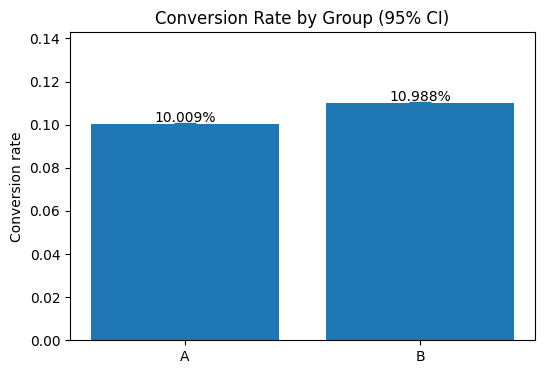

In [62]:
fig, ax = plt.subplots(figsize=(6,4))
x = np.arange(len(summary))
rates = summary['conversation_rate'].values
yerr = [rates - summary['ci_low'].values, summary['ci_upp'].values - rates]

ax.bar(x, rates, tick_label=summary['group'].values)
ax.errorbar(x, rates, yerr=yerr, fmt='none', capsize=8)
ax.set_ylabel('Conversion rate')
ax.set_title('Conversion Rate by Group (95% CI)')
for i, v in enumerate(rates):
    ax.text(i, v + 0.001, f"{v:.3%}", ha='center')
plt.ylim(0, max(summary['ci_upp'].max()*1.1, rates.max()*1.3))
plt.show()

In [66]:
print("=== Summary Table ===")
display(summary)

print("\n=== Statistical Tests ===")
print(f"z-statistic = {z_stat:.4f}")
print(f"p-value = {p_val:.4f}")
print(f"Cohen's h (B vs A) = {h:.4f}")
print(f"Estimated power (current sample) = {power_current:.3f}")

alpha = 0.05
if p_val < alpha:
    print("\nDecision (statistical): Reject null hypothesis -> difference is significant.")
    # Business decision heuristic:
    if h > 0:
        print("Business decision: B outperforms A. Recommend rollout of variant B if business risk acceptable.")
    else:
        print("Business decision: A outperforms B. Do NOT roll out B.")
else:
    print("\nDecision (statistical): Fail to reject null -> no significant difference.")
    print("Business decision: Keep current (A) or increase sample size / examine segments.")

print("\nRisks & limitations:")
print("- No user_id: duplicates/sessions not deduplicated; estimates are per-row.")
print("- Possible confounders (traffic_source, device_type, region) not adjusted.")
print("- If groups are not balanced over time, temporal bias possible.")
print("\nNext steps suggestions:")
print("- Check balance by traffic_source/device/time.")
print("- Run segmented analysis (by device, region).")
print("- If power low, collect more data to reach ~80% power for observed effect size.")


=== Summary Table ===


,group,users,conversions,conversation_rate,ci_low,ci_upp
0,A,1000000,100092,0.100092,0.099504,0.100680
1,B,1000000,109884,0.109884,0.109271,0.110497



=== Statistical Tests ===
z-statistic = -22.5877
p-value = 0.0000
Cohen's h (B vs A) = -0.0320
Estimated power (current sample) = 1.000

Decision (statistical): Reject null hypothesis -> difference is significant.
Business decision: A outperforms B. Do NOT roll out B.

Risks & limitations:
- No user_id: duplicates/sessions not deduplicated; estimates are per-row.
- Possible confounders (traffic_source, device_type, region) not adjusted.
- If groups are not balanced over time, temporal bias possible.

Next steps suggestions:
- Check balance by traffic_source/device/time.
- Run segmented analysis (by device, region).
- If power low, collect more data to reach ~80% power for observed effect size.
